In [1]:
import pathpy as pp
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
from ast import literal_eval
import time
import warnings
import pickle
import sys
import neptune

warnings.filterwarnings('ignore')

In [2]:
# add paths for modules
sys.path.append('../src/models')
sys.path.append('../src/features')
sys.path.append('../src/visualization')
sys.path.append('../src/datawrangling')

import dataloader_paths, dataloader_geo
from maritime_traffic_network import MaritimeTrafficNetwork
from MOGen_path_prediction import MOGenPathPrediction
from dijkstra_path_prediction import DijkstraPathPrediction
from random_path_prediction import RandomWalkPathPrediction
import prediction_model_evaluation_metrics as metrics

In [3]:
# Experiment parameters
datasize = 'full'
location = 'stavanger'
network_date = '202204'
train_dates = ['202204', '202205', '202207']
test_dates = ['202206']
filter = 'Tank'
DP_tol = 30
min_samples = 25

In [4]:
# Load a network model from pickle
network_name = network_date+'_waypoints_DP'+str(DP_tol)+'_HDBSCAN'+str(min_samples)+'_'+location+'_'+datasize+'_UTM'
network_path = '../models/networks/best_networks/' + network_name + '.obj'
fileObj = open(network_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()
network.hyperparameters

{'Data': '../../data/processed/202204_points_stavanger_cleaned_meta_full_dualSplit_2.parquet',
 'DP_tolerance': 30,
 'clustering_method': 'HDBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 25,
 'clustering_min_cluster_size': 25,
 'clustering_eps': 0,
 'clustering_metric_V': array([[1.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 1.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.01, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.01, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  ]]),
 'graph_generation_max_distance': 20,
 'graph_generation_max_angle': 45,
 'merge_stops_speed': 2}

In [5]:
# Load training data from file
path_prefix = '../data/paths/'
training_paths = dataloader_paths.load_path_training_data(path_prefix, network_name, train_dates, filter=filter, data_version='')

36924
730 training paths loaded.


In [6]:
traj_path_prefix = '../data/processed/'
all_test_paths = dataloader_paths.load_path_test_data(path_prefix, network_name, test_dates, 
                                                      0, -1, 1, filter=filter, data_version='')
test_trajectories = dataloader_geo.load_trajectories(traj_path_prefix, location, network.crs, test_dates)

12250
268 test paths loaded.


https://app.neptune.ai/jandrik91/RoutePredictions/e/ROUT-367


order:  4; log_L (8 prcs): 100%|██████████████████| 1/1 [00:00<00:00,  1.32it/s]

Selected optimal maximum order K=1 from candidates.
MOGen model
- Model Selection ------------------------------------
 K  |   nodes     edges   |   log L    dof         AIC
 1  |    573      12206   | -6355.82   1434   15579.64
 2  |   1295      12206   | -4841.67   4009   17701.34
 3  |   2173      12206   | -4041.87  11037   30157.74
 4  |   3046      12206   | -3380.05  30438   67636.11
Making predictions for 1168 samples with MOGen of order 1
Progress: 

10%...20%...30%...40%...50%...60%...70%...80%...90%...Done!
Evaluating 1166 samples for next_nodes prediction task
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...90%...Done!


Time elapsed: 0.36 minutes


Percentage of unsuccessful predictions: 0.09%
Mean SSPD: 1693.05m
Median SSPD: 124.84m
Mean choice_accuracy: 0.5950


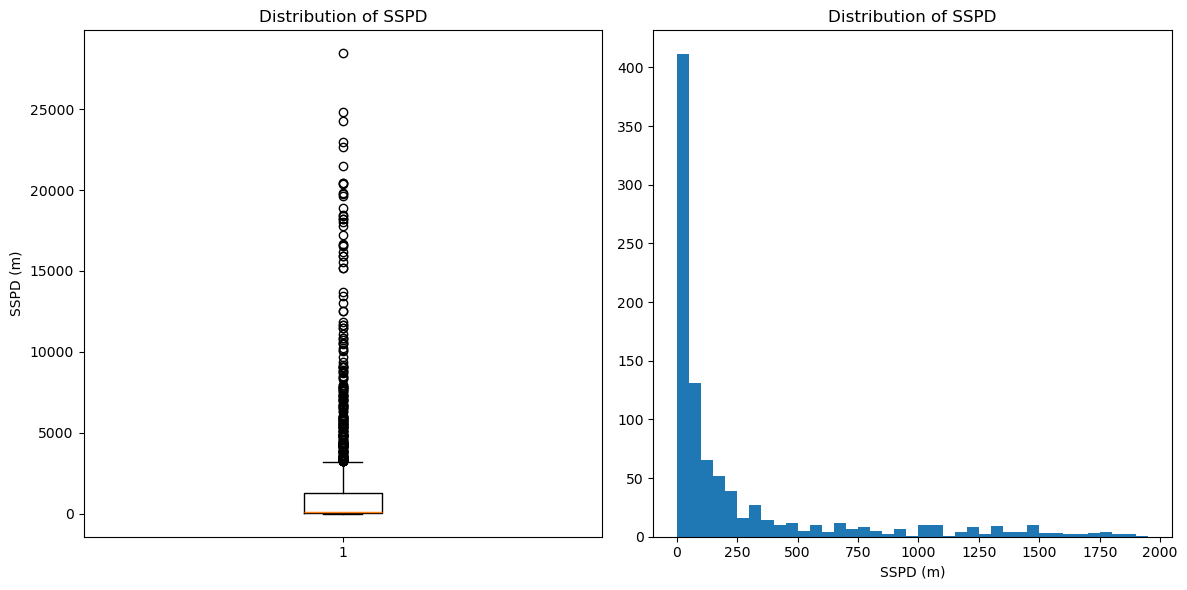

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 39 operations to synchronize with Neptune. Do not kill this process.
All 39 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/jandrik91/RoutePredictions/e/ROUT-367/metadata


In [7]:
# make experiments
prediction_task = 'next_nodes'  # 'next_nodes' or 'path'
eval_mode = 'path'
model_type = 'MOGen'
vals_n_steps = [10]
vals_n_walks = [1000]
vals_max_order = [4]
vals_order = [0]
MOGen_training_mode = 'partial'
vals_n_start_nodes = [1]
weight_vals = ['length', 'inverse_passages', 'inverse_density']

# choose test paths
selection_start = 0
selection_end = -1
selection_step = 2

# run experiments
for i in range (0, len(vals_n_walks)):
    run = neptune.init_run(
        project="jandrik91/RoutePredictions",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxYmQzMjgwZS1jZGYwLTQ2YjktYWNjOS02MjBlZWEzNzUzNDcifQ==",
    )  # your credentials

    # training parameters
    n_walks = vals_n_walks[i]
    MOGen_max_order = vals_max_order[i]
    n_start_nodes = vals_n_start_nodes[i]
    n_steps = vals_n_steps[i]
    order = vals_order[i]

    # prepare test data
    if prediction_task == 'next_nodes':
        # split test paths in subpaths
        sub_paths = dataloader_paths.split_path_data(all_test_paths, n_steps+1)
        test_paths = dataloader_paths.sample_path_data(sub_paths, selection_start, selection_end, selection_step)
    else:
        test_paths = dataloader_paths.sample_path_data(all_test_paths, selection_start, selection_end, selection_step)
    n_test_paths=len(test_paths)
        
    # train and predict
    if model_type == 'Dijkstra':
        model = DijkstraPathPrediction()
        model.train(network.G_pruned, training_paths)
        predictions = model.predict(test_paths, n_start_nodes=n_start_nodes, weight=weight_vals[i])
    if model_type == 'MOGen':
        model = MOGenPathPrediction()
        model.train(training_paths, max_order=MOGen_max_order, model_selection=True, training_mode=MOGen_training_mode)
        predictions = model.predict(prediction_task, test_paths, network.G, 
                                    n_start_nodes=n_start_nodes, n_steps=n_steps, 
                                    n_predictions=1, n_walks=n_walks, order=order)
    if model_type == 'Random':
        model = RandomWalkPathPrediction()
        model.train(network.G_pruned, training_paths)
        predictions = model.predict(test_paths, n_start_nodes, n_steps, 
                                    1, n_walks, method='random')
    if model_type == 'Markov':
        model = RandomWalkPathPrediction()
        model.train(network.G_pruned, training_paths)
        predictions = model.predict(test_paths, n_start_nodes, n_steps, 
                                    1, n_walks, method='weighted')
        
    # evaluate
    evaluation_results, fig = metrics.evaluate_given_predictions(prediction_task, predictions, test_trajectories, 
                                                                 network, n_start_nodes=n_start_nodes, n_steps=n_steps, eval_mode=eval_mode)
    nan_mask = evaluation_results.isna().any(axis=1)
    failure_rate = nan_mask.sum() / len(evaluation_results)
    mean_abs_err = np.mean(evaluation_results[~nan_mask]["SSPD"])
    median_abs_err = np.median(evaluation_results[~nan_mask]["SSPD"])
    choice_accuracy = np.mean(evaluation_results[~nan_mask]["choice_accuracy"])

    # save experiment
    run["network_name"] = network_name
    run["n_points"]=len(network.gdf)
    run["n_nodes"]=network.G.number_of_nodes()
    run["n_edges"]=network.G.number_of_edges()
    
    params = network.hyperparameters
    params['clustering_metric_V_coord'] = params['clustering_metric_V'][0][0]
    params['clustering_metric_V_cog'] = params['clustering_metric_V'][2][2]
    params['clustering_metric_V_speed'] = params['clustering_metric_V'][4][4]
    run["network_parameters"] = params
    
    run["training_data"] = {'training_dates':str(train_dates),
                            'n_training_paths':len(training_paths)}
    
    run["test_data"] = {'test_dates':str(test_dates),
                        'selection_start':selection_start,
                        'selection_end':selection_end,
                        'selection_step':selection_step,
                        'n_test_paths':n_test_paths}
    
    run["prediction_task"] = prediction_task
    run["eval_mode"] = eval_mode
    run["model_type"] = model_type
    run["MOGen_n_walks"] = n_walks
    run["MOGen_max_order"] = MOGen_max_order
    if model_type == 'MOGen':
        run["MOGen_optimal_order"] = model.order
    if model_type == 'Dijkstra':
        run["weight"] = weight_vals[i]
    run["MOGen_training_mode"] = MOGen_training_mode
    run["n_start_nodes"] = n_start_nodes
    run["n_steps"] = n_steps
    
    run["plot"].upload(fig)
    run["failure_rate"] = failure_rate
    run["mean_abs_err"] = mean_abs_err
    run["median_abs_err"] = median_abs_err
    run["choice_accuracy"] = choice_accuracy
    run["filter"] = filter
    
    run.stop()

In [8]:
len(test_paths)

1168